# Problem Set 1 - K-Nearest Neighbor and NaiveBayes classifiers
## CSCI 5622 - Spring 2022


Student name: Harsh Gupta
Only submit this notebook to canvas (no zip files).

For today's assignment, we will be implementing our own K-Nearest Neighbors classifier (KNNClassifier) algorithm and a Naive Bayes classifier. 

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But
1. I'll know that you know what's really going on
2. You'll know you can do it, because
    1. someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to
learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...),
    2. maybe because you're working on something important, and you need to control exactly what's on there
(should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors
import data
import tests
%matplotlib inline

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*
 Yes - but it also has a ton of helper functions that we'll be using later.

You will be guided through the different questions and you'll be expected to complete the classes and the functions following the provided signatures.
 Sometimes at the end of a question we would provide a difficulty estimate using
the average scored by students who attempted the question (or a similar one) in previous assignments.

Remember to avoid adding positional arguments and make sure the returned values have the correct format (this applies to all assignments).
The alternative is that your solution might be rejected by the auto-grader (we won't be debugging your code).
We will provide some basic sanity checks. They're in no means exhaustive and passing them does not imply
your solution is 100% correct.


For example, you're required to complete the method `compute_something` of class A.
We provide examples of acceptable solutions.

In [2]:
# This cell can be removed from the submitted notebook
class A:
    def compute_something(self, X):
        """
        :return: numpy array of zeros, with shape (4,)
        """
        # BEGIN
        answer = None
        # END
        return answer


class A1:  # Acceptable solution:
    # - the added y is an optional argument and omitting it does not affect the solution
    # - the returned object has the expected structure.
    def compute_something(self, X, y=None):
        # BEGIN
        return np.zeros((4,))
        # END


class A2:  # Wrong format:
    # - your solution requires a new positional argument y!
    # - the returned object does not have the expected format!
    # - solution outside the delimiters # BEGIN # END
    def compute_something(self, X, y):
        return [0, 0, 0, 0]


class A3:  # Acceptable solution:
    # You're free to add your own helper functions/methods
    def compute_something(self, X):
        # BEGIN
        return self.get_zeros(4)
        # END

    def get_zeros(self, i):
        return np.zeros((i,))


First, let's also load a dataset to play with and start working to build out our own classifier.

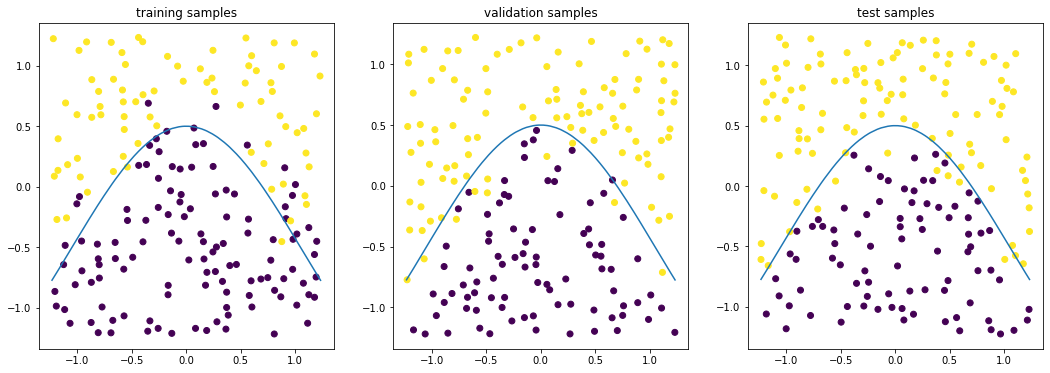

In [3]:
binary_data = data.BinaryData()
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
for i, name in enumerate(["training", "validation", "test"]):
    axs[i].plot(*binary_data.boundary())
    axs[i].set_title("%s samples" % name)
axs[0].scatter(binary_data.X_train[:, 0], binary_data.X_train[:, 1], c=binary_data.y_train)
axs[1].scatter(binary_data.X_valid[:, 0], binary_data.X_valid[:, 1], c=binary_data.y_valid)
axs[2].scatter(binary_data.X_test[:, 0], binary_data.X_test[:, 1], c=binary_data.y_test)
plt.show()

We have data! The `binary_data` instance has the following attributes:
   - a training set (`X_train, y_train`): to train the model and on which the prediction is based
   - a validation set (`X_valid, y_valid`): to select the best __hyper-parameters__ of the model
   - a test set (`X_test, y_test`): to evaluate the performance of the model on unseen data

### Problem 1: Complete our KNN Classifier - 30 Points

The KNNClassifier class we're implementing will have similar design to the K-Nearest Neighbors classifier class from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- A `fit` method that uses the training data
- A `predict` method that returns the predicted labels given data `X`

We've written out a lot of the structure for you for consistency across different parts of the assignment and so
you can focus on the "important" stuff that actually relates to the machine learning itself.

In [4]:
class KNNClassifier:

    def __init__(self, k=5):
        """
        Initialize our custom KNN classifier
        :param k: the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._ball_tree = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None
        self.population_most_common = None

    def fit(self, X, y):
        """
        Fit the model using the provided data
        :param X: 2-D np.array of shape (number training samples, number of features)
        :param y: 1-D np.array of shape (number training samples,)
        :return: self
        """
        self._ball_tree = sklearn.neighbors.BallTree(X)  # See documentation of BallTree and how it's used
        self._y = y
        # Should be used to map the classes to {0,1,..C-1} if needed (C is the number of classes)
        # We can assume that the training data contains samples from all the possible classes
        classes = np.unique(y)
        self.label_to_index = dict(zip(classes, range(classes.shape[0])))
        self.index_to_label = dict(zip(range(classes.shape[0]), classes))

        label_values, label_counts = np.unique(y, return_counts=True)
        self.training_most_common = label_values[np.argmax(label_counts)]

        return self

    def majority_vote(self, indices_nearest_k, distances_nearest_k=None):
        """
        Given indices of the nearest k neighbors for each point, report the majority label of those points.
        :param indices_nearest_k: np.array containing the indices of training neighbors, of shape (M, k)
        :param distances_nearest_k: np.array containing the corresponding distances of training neighbors, of shape (M, k)
        :return: The majority label for each row of indices, shape (M,)
        """

        # Workspace 1.1
        # TODO: Determine majority for each row of indices_nearest_k
        # TODO: if there is a tie, set the label to the most common label in the training set
        #BEGIN
        #Getting most common in population
        y_converted=[]
        for m in self._y: y_converted.append(self.label_to_index[m])
        y_converted = np.array(y_converted)
        self.population_most_common = self.index_to_label[np.bincount(y_converted).argmax()]
        
        neighbor_y = {}
        voted_labels = []
        for index in indices_nearest_k:#[[3, 4], [1, 6]]
            voted_label = []
            neighbor_y = {}
            for neighbor in index:
                neighbor_y[self._y[neighbor]]= neighbor_y.get(self._y[neighbor],0)+1
            voted_label = [y_val for y_val, count in neighbor_y.items() if count == max(neighbor_y.values())]
            if(len(voted_label) > 1): voted_labels.append(self.population_most_common)
            else: voted_labels.append(voted_label[0])
        voted_labels= np.array(voted_labels)
        #END
        return voted_labels

    def predict(self, X, make_model_consistent = False):
        """
        Given new data points, classify them according to the training data provided in fit and number of neighbors k
        You should use BallTree to get the distances and indices of the nearest k neighbors
        :param X: feature vectors (num_points, num_features)
        :return: 1-D np.array of predicted classes of shape (num_points,)
        """
        # Workspace 1.2
        #BEGIN 
        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, self._k)
        
        #Modification as needed by 1.7b to make model consistent
        if make_model_consistent:
            for ind,row in enumerate(X):
                if ind in indices_nearest_k[ind]:
                    indices_nearest_k[ind] = [ind]*self._k

        #END
        return self.majority_vote(indices_nearest_k, distances_nearest_k)

    def confusion_matrix(self, X, y):
        """
        Generate the confusion matrix for the given data
        :param X: an np.array of feature vectors of points, shape (N, n_features)
        :param y: the corresponding correct classes of our set, shape (N,)
        :return: a C*C np.array of counts, where C is the number of classes in our training data
        """
        # Workspace 1.3
        # The rows of the confusion matrix correspond to the counts from the true labels, the columns to the predictions'
        # TODO: Run classification for the test set X, compare to test answers y, and add counts to matrix
        #BEGIN 
        c_matrix = np.zeros((len(self.label_to_index), len(self.label_to_index)))
        y_pred = self.predict(X)
        for i in range(len(y)):
            c_matrix[self.label_to_index[y[i]]][self.label_to_index[y_pred[i]]] += 1
        #END
        return c_matrix

    def accuracy(self, X, y, make_model_consistent= False):
        """
        Return the accuracy of the classifier on the data (X_test, y_test)
        :param X: np.array of shape (m, number_features)
        :param y: np.array of shape (m,)
        :return: accuracy score [float in (0,1)]
        """
        # Workspace 1.4
        # TODO: Compute accuracy on X
        #BEGIN 
        y_pred = self.predict(X,make_model_consistent)
        score = np.sum(np.equal(y, y_pred)) / len(y)
        #END
        return score

In [5]:
# Test cell, uncomment to run the tests
tests.testKNN(KNNClassifier)

Question 1.1: [PASS]
Question 1.2: [PASS]
Question 1.3: [PASS]
Question 1.4: [PASS]


*But professor, this code isn't complete!*

1.1 [5 points] Complete the `majority_vote` function to determine the majority class of a series of neighbors.
If there is a tie, then you should remove the farthest element until the tie is broken. (Avg __4.6__)

1.2 [5 points] Complete the `predict` function to capture the predicted class of a new datapoint (Avg __4.9__)

 - HINT: Use the BallTree documentation to determine how to retrieve neighbors from the model (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

1.3 [5 points] Complete the `confusion_matrix` function to reveal the results of classification (Avg __5__)

1.4 [5 points] Complete the `accuracy` function to get accuracy of the classifier based on a given test data (Avg __5__)

Below, we'll be using our KNNClassifier (sent in as "model") to show how we would predict any points in space given the input data.

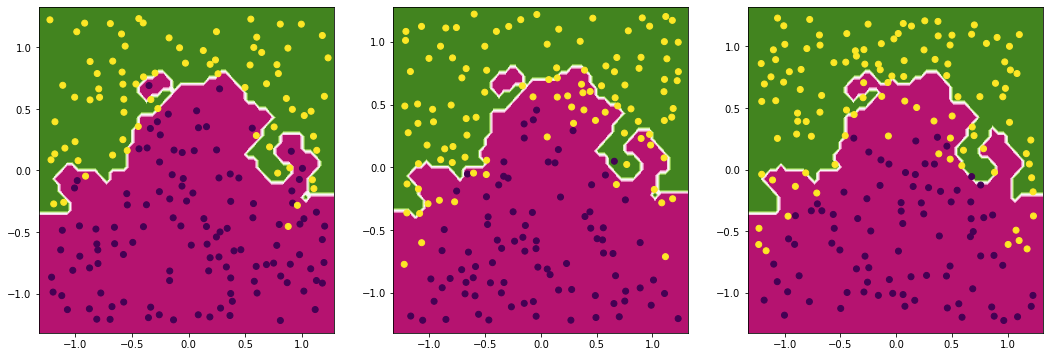

In [6]:
# This cell is to show the decision surface of the classifier
# You can change k to visualize KNN behavior
knn = KNNClassifier(2).fit(binary_data.X_train, binary_data.y_train)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
tests.show_decision_surface(knn, binary_data.X_train, binary_data.y_train, axs[0])
tests.show_decision_surface(knn, binary_data.X_valid, binary_data.y_valid, axs[1])
tests.show_decision_surface(knn, binary_data.X_test, binary_data.y_test, axs[2])
plt.show()

1.5 [5 points] For each k in the range [1,32], fit a KNNClassifier on the training set and plot the accuracies on training and validation
data versus k. What's the value of k that yields the best accuracy on the training set? on the validation set? Which one
 should we choose? (Avg __4.8__)

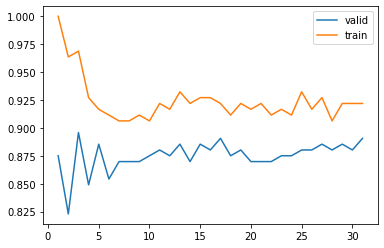

In [7]:
# Workspace 1.5.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k in ks:
    #BEGIN 
    # code here
    knn = KNNClassifier(k).fit(binary_data.X_train, binary_data.y_train)
    accuracies_train.append(knn.accuracy(binary_data.X_train, binary_data.y_train))
    accuracies_valid.append(knn.accuracy(binary_data.X_valid, binary_data.y_valid))
    #END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()

### # Workspace 1.5.b
% Write up: best k for training and validation sets, and which one should we choose

% The k value that gives the best accuracy (**1**) on the training set is **k=1**.

The k value that gives the best accuracy (**0.895834**) on the validation set is **k=3**.

We choose **3** as the best k value for the above dataset. **K = 3** gives us an an **accuracy of ~89.58% on the validation set and that of 96.875% on the training set**. This is the highest accuracy that we could get for k ranging from 1 to 32 for the above dataset on both the set (Note: We are ignoring the accuracy of k=1 on training set as that will always be 100% due to the fact that the datapoint's closest single neighbor on the train set is the point itself).

1.6 [5 points] Report the accuracy and the confusion matrix on the test set using the value of k chosen in 1.5 (Avg __5__)

In [8]:
# Workspace 1.6
# TODO: print the accuracy and confusion matrix on the test set using k from 1.5
#BEGIN 
knn = KNNClassifier(3).fit(binary_data.X_train, binary_data.y_train)
print("Accuracy on test set with k = 3 is",knn.accuracy(binary_data.X_test, binary_data.y_test))
print("The confusion matrix on the test set using k as 3:")
print(knn.confusion_matrix(binary_data.X_test, binary_data.y_test))
#END

Accuracy on test set with k = 3 is 0.890625
The confusion matrix on the test set using k as 3:
[[81.  2.]
 [19. 90.]]


**Bonus (for the avid machine learner) (4 Points)**

1.7.a [1 point] A [__consistent classifier__](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf)
on the training data is defined as a classifier that reaches 100% accuracy on the training set. For which values of k is KNNClassifier Consistent? (Avg __0.5__)

1.7.b [2 points] Edit your `KNNClassifier` so that it's consistent for all $k$ (we made sure that the change does not affect the sanity checks) (Avg __1__)

#### Write-up for the bonus
**Workspace 1.7.a**

% for which k in KNNClassifier consistent

% The classifier is consistent for k=1 on the training dataset. It will always achieve the accuracy of 100% on training data due to the fact that the datapoint's closest single neighbor on the train set is the point itself.

**Workspace 1.7.a**

Running the acuuracy by passing **make_model_consistent = True** makes our KNN consistent and we get an acuuracy of 1 or 100% for all values of k while predicting the training samples.

***
OK - now we've demonstrated that our KNN classifier works, let's think about our problem space! 

## Our Dataset - Identifying Digits from Images

It's a pretty common problem - just imagine working at the post office, and you're handed a hand-written check,
and you have to identify exactly what it says.
Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?


### Problem 2: Improving KNN on Digits dataset - 20 Points

2.1 [4 points] `report` the number of examples different partitions of the digit dataset adn the number of pixels in the images (Avg __3.8__)

2.2 [6 points] complete the `evaluate` to perform the same evaluation we did in 1.5:
 - For k in range (1, 20):
    - initialize the classifier for k  and train in on the training set
    - Compute the accuracy on the validation set and save it
 - Choose k with the best accuracy on the validation set
 - Report the accuracy and the confusion matrix on the test set (use `display_confusion` for a cleaner output)


In [24]:
class Numbers:
    def __init__(self):
        self.data = data.DigitData() # it has the same structure as binary_data

    def report(self):
        """
        Report information about the dataset using the print() function
        """
        # Workspace 2.1
        #TODO: Create printouts for reporting the size of each set and the size of each datapoint
        #BEGIN 
        print("Training Data")
        print("\t #Rows:", self.data.X_train.shape[0],"\n\t #Features (Number of pixels):",self.data.X_train.shape[1])
        print("Testing Data")
        print("\t #Rows:", self.data.X_test.shape[0],"\n\t #Features (Number of pixels):",self.data.X_test.shape[1])
        print("Validation Data")
        print("\t #Rows:", self.data.X_valid.shape[0],"\n\t #Features (Number of pixels):",self.data.X_valid.shape[1])
        #END

    def evaluate(self, classifier_class):
        """
        evaluates instances of the classifier class for different values of k and performs model selection
        :param classifier_class: Classifier class (either KNNClassifier or WeightedKNNClassifier)
        """

        # Workspace 2.2
        #BEGIN 
        # code here (anything between BEGIN and END is yours to edit if needed)
        best_valid_k = None
        confusion_matrix = None
        accuracy = 0
        ks = list(range(1, 20))
        accuracies_valid = []
        for k in ks:
            knn = classifier_class(k).fit(self.data.X_train, self.data.y_train)
            accuracies_valid.append(classifier_class.accuracy(knn,self.data.X_valid, self.data.y_valid))
            print("Validating model on k =",k, end="\r")
        print("\n")
        best_valid_k = accuracies_valid.index(max(accuracies_valid))+1
        knn = classifier_class(best_valid_k).fit(self.data.X_train, self.data.y_train)
        accuracy = classifier_class.accuracy(knn,self.data.X_test, self.data.y_test)
        confusion_matrix = classifier_class.confusion_matrix(knn,self.data.X_test, self.data.y_test)
        #END
        print("best k:", best_valid_k)
        print("Accuracy on test set:", accuracy)
        self.display_confusion(confusion_matrix)

    def view_digit(self, index, partition):
        """
        Display a digit given its index and partition
        :param index: index of the digit image
        :param partition: partition from which the digit is retrieved, either "train", "valid" or "test"
        """
        image = {"train": self.data.X_train, "valid": self.data.X_valid, "test": self.data.X_test}[partition][index]
        label = {"train": self.data.y_train, "valid": self.data.y_valid, "test": self.data.y_test}[partition][index]
        image = image.reshape(28, 28)
        plt.figure()
        plt.matshow(image)
        plt.title("Digit %i" % label)
        plt.show()

    @staticmethod
    def display_confusion(c_matrix):
        """
        Displays the confusion matrix using matshow
        :param c_matrix: square confusion matrix, shape (num_classes, num_classes)
        """
        _, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j, i]), va='center', ha='center')
        plt.show()


Training Data
	 #Rows: 1000 
	 #Features (Number of pixels): 784
Testing Data
	 #Rows: 500 
	 #Features (Number of pixels): 784
Validation Data
	 #Rows: 500 
	 #Features (Number of pixels): 784
Validating model on k = 19

best k: 3
Accuracy on test set: 0.866


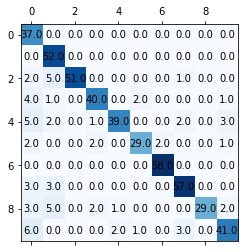

In [25]:
# Run evaluate of Numbers and shopws the confusion matrix
numbers = Numbers()
numbers.report()
numbers.evaluate(KNNClassifier)

*Wow, I can't believe we just created a KNN Classifier for multiple classes - but can't we make it better?*

Yes, we saw above that our classifier didn't work perfectly. Let's explore try to understand why.


2.3 [10 points] Determine which classes are most often confused (from our confusion matrix above),
 inspect some examples of these digits (using the `view_digit` function in our Numbers class),
 and write a brief (4 - 5 sentences) description of why you think these particular numbers may be misclassified. (Avg __9.1__)

2 is majorly misclassified as [1]
3 is majorly misclassified as [0]
4 is majorly misclassified as [0]
8 is majorly misclassified as [1]
9 is majorly misclassified as [0]
Input to our model from test


<Figure size 432x288 with 0 Axes>

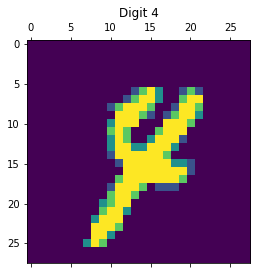

Sample from training how 0 looks like


<Figure size 432x288 with 0 Axes>

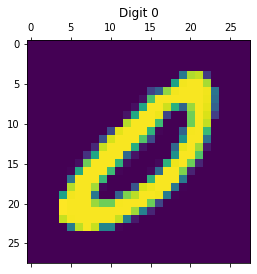

Sample from training how 4 looks like


<Figure size 432x288 with 0 Axes>

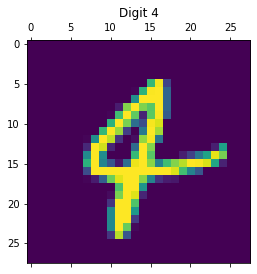

Input to our model from test


<Figure size 432x288 with 0 Axes>

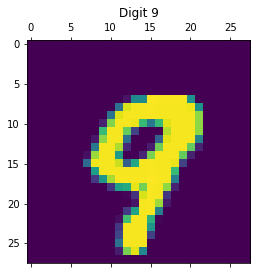

Sample from training how 0 looks like


<Figure size 432x288 with 0 Axes>

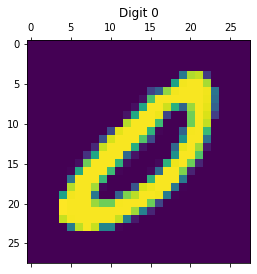

Sample from training how 9 looks like


<Figure size 432x288 with 0 Axes>

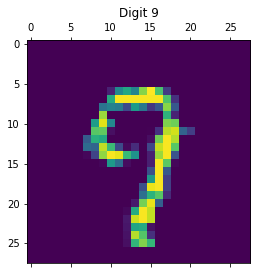

In [27]:
# Workspace 2.3.a
#TODO: Print out problem class images
#BEGIN

#Method to get the index of first image from dataset
def index_of(num: int, partition: str):
    label = {"train": numbers.data.y_train, "test": numbers.data.y_test}[partition]
    return np.argwhere(label==num)[0]

#Getting confusion matrix
knn = KNNClassifier(3).fit(numbers.data.X_train, numbers.data.y_train)
confusion_matrix = knn.confusion_matrix(numbers.data.X_test, numbers.data.y_test)

#determining numbers which were misclassified more than thrice
classification_error=[[]]*10
for row_ind, row in enumerate(confusion_matrix):
    sample_error=[]
    for col_ind, col in enumerate(row):
        if(col_ind!=row_ind and col>3): sample_error.append(col_ind)
        classification_error[row_ind] = sample_error
for i,misclassification in enumerate(classification_error):
    if(len(misclassification)>0): print(i,"is majorly misclassified as",misclassification)
#Compare few images in train and test for the misclassified samples
print("Input to our model from test")
numbers.view_digit(index_of(4,"test"),"test")
print("Sample from training how 0 looks like")
numbers.view_digit(index_of(0,"train"),"train")
print("Sample from training how 4 looks like")
numbers.view_digit(index_of(4,"train"),"train")

print("Input to our model from test")
numbers.view_digit(index_of(9,"test"),"test")
print("Sample from training how 0 looks like")
numbers.view_digit(index_of(0,"train"),"train")
print("Sample from training how 9 looks like")
numbers.view_digit(index_of(9,"train"),"train")

# code here
#END

**Workspace 2.3.b**

TODO: Write description of mis-classification

% Mis-classification occurs since KNN mearly compares the pixels in the test with those in the training dataset.The individual pixels on different numbers overlap with each other.


Mostly 9 and 4 are misclassified and it's because the numbers are written in various different styles in our dataset. Any number which has a loop/circle or a curve (like 3,9,4) can have lots of overlapping pixels with 0 if say the loop ends up taking most amount of space. Similarly if numbers are written in the form where the adjescent parts are very close to each other resembling a straight line, then they can be misclassified as 1.

### Problem 3 : Improving KNN on MNIST using WeightedKNN (25 pts)
Complete the `WeightedKNNClassifier` class to perform the weighted KNN classification.
The Weighted KNN classifier assigns weights to the nearest-neighbor training examples proportional to
 the inverse-distance from the training example to the query point.

Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote.
 Mathematically, we might describe the weighted-vote for a class $c$ as

\begin{align}
\textrm{Weighted-Vote}(c)(x) = \sum_{i \in {\cal N}_K(x)} I(y_i \in c) \times \frac{1}{\|{\bf x}_i - {\bf x}\|}
\end{align}

where ${\cal N}_K(x)$ is the set of the nearest $k$ neighbors to $x$.

3.1 [10 points] Complete `weighted_vote`: it's certainly possible that a query point could be distance $0$ away from some training example.
 If this happens your implementation should handle it and return the appropriate class label.(Avg __7.8__)

3.2 [5 points] Complete `predict`. (Avg __4.9__)


In [12]:
class WeightedKNNClassifier(KNNClassifier):

    def weighted_vote(self, indices_nearest_k, distances_nearest_k):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param indices_nearest_k: The indices of the K nearest neighbors in self.X_train
        :param distances_nearest_k: Corresponding distances from query point to K nearest neighbors.
        """
        # Workspace 3.1
        #BEGIN 
        voted_labels = []
        for index_sample, sample in enumerate(indices_nearest_k):#[[3, 4], [1, 6]]
            voted_label = []
            neighbor_y = {}
            flag_for_hit = False
            while(len(voted_label)!=1 and not flag_for_hit):
                for index_neighbor, neighbor in enumerate(sample):
                    distance = distances_nearest_k[index_sample][index_neighbor]
                    if(distance == 0): flag_for_hit=True; voted_labels.append(self._y[neighbor]);break;
                    neighbor_y[self._y[neighbor]]= neighbor_y.get(self._y[neighbor],0)+(1/distance)
                if(not flag_for_hit):
                    voted_label = [y_val for y_val, count in neighbor_y.items() if count == max(neighbor_y.values())]
                    if(len(voted_label) > 1): sample = sample[:-1]
                    else: voted_labels.append(voted_label[0])
        labels= np.array(voted_labels)
        #END

        return labels

    def predict(self, X, make_model_consistant = False):
        """
        Given an np.array of query points, return y_hat, an np.array of predictions
        :param X: an (m x p) dimension np.array of points to predict labels for
        """

        # Workspace 3.2
        ##BEGIN 
        # code here
        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, self._k)
        labels = self.weighted_vote(indices_nearest_k, distances_nearest_k)
        #END
        return labels

In [13]:
# Test cell, uncomment to run the tests
tests.testWeightedKNN(WeightedKNNClassifier)

Question 3.1: [PASS]
Question 3.2: [PASS]


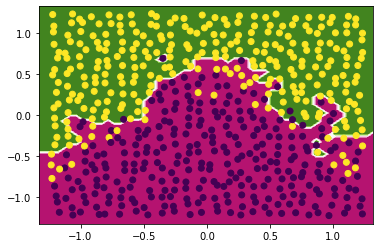

In [14]:
# Example on how to use the show_decision_surface
knn = WeightedKNNClassifier(3).fit(binary_data.X_train, binary_data.y_train)
tests.show_decision_surface(knn, binary_data.X, binary_data.y)

3.3 [5 points] Evaluate `WeightedKNNClassifier` on the binary data, similar to 1.5 digits data using `Numbers` class and compare it to `KNNClassifier` (Avg __4.6__)

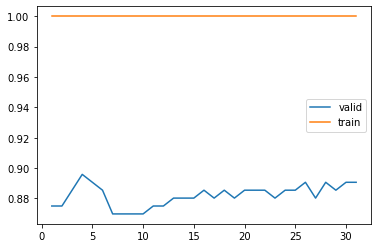

0.8958333333333334


In [15]:
# Workspace 3.3.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k in ks:
    #BEGIN 
    knn = WeightedKNNClassifier(k).fit(binary_data.X_train, binary_data.y_train)
    accuracies_train.append(knn.accuracy(binary_data.X_train, binary_data.y_train))
    accuracies_valid.append(knn.accuracy(binary_data.X_valid, binary_data.y_valid))
    #END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()
best_k = np.argmax(accuracies_valid)+1
print(np.max(accuracies_valid))

### # Workspace 3.3.b
% Write up: Which classifier does better on the binary data

% On the binary data **validation set** the max accuracy of KNNClassifier (which is at k=3) and max accuracy of WeightedKNNClassifier (at k=4) are both same at **0.895834**.

On the binary data **test set** the max accuracy of KNNClassifier (which is at k=3) is **0.890625** and max accuracy of WeightedKNNClassifier (at k=4) is **0.875**. 

Conclusion: **The KNNClassifier performs better than WeightedKNNClassifier on the binary data set**



3.4 [5 points] Compare `WeightedKNNClassifier` to `KNNClassifier` on the digits' data using `Numbers` class.

Evaluating on KNNClassifier
Validating model on k = 19

best k: 3
Accuracy on test set: 0.866


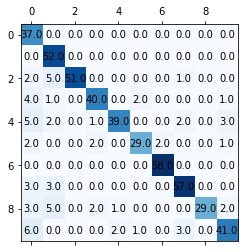

Evaluating on WeightedKNNClassifier
Validating model on k = 19

best k: 4
Accuracy on test set: 0.894


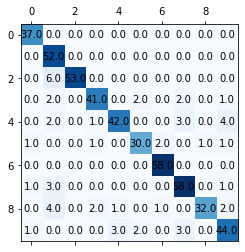

In [28]:
#Workspace 3.4.a
#BEGIN 
numbers = Numbers()
print("Evaluating on KNNClassifier")
numbers.evaluate(KNNClassifier)
print("Evaluating on WeightedKNNClassifier")
numbers.evaluate(WeightedKNNClassifier)
#END


#### 3.4.b write-up
% As we can see above, using the WeightedKNNClassifier increased the accuracy from 0.866 to 0.894 which is approximately a 3% increase. We must also note the confusion matrix has less misclassifications as compared to earlier.

#### Bonus
3.5 [2 points] Is `WeightedKNNClassifier` a consistent classifier? why? (Avg __1.1__)


#### 3.5 write-up
% The WeightedKNNClassifier is a consistent classifier. This is because the classifier gives 100% accuracy on the training set. The model takes in inverse of distance as weight so if the datapoint received for prediction already exists in the training set, the weights for the nearest neighbor (the number itself) will be highest thereby returning the label y with 100% accuracy regardless of the k. This can be verified by observing the accuracy plot in quesiton 3.3 which is a straight line at 1.

### Problem 4 - Naive Bayes [25 points]
***
Consider the problem of predicting whether a person has a college degree based on age, salary, and Colorado residency.
The dataset looks like the following.

|Age|Salary|Colorado Resident| Has Siblings | College degree|
|:------:|:-----------:| :----------:| :----------:|--:|
| 37 | 44,000 | Yes | No  | Yes|
| 61 | 52,000 | Yes | No  | No |
| 23 | 44,000 | No  | No  | Yes|
| 39 | 38,000 | No  | Yes | Yes|
| 48 | 49,000 | No  | No  | Yes|
| 57 | 92,000 | No  | Yes | No |
| 38 | 41,000 | No  | Yes | Yes|
| 27 | 35,000 | Yes | No  | No |
| 23 | 26,000 | Yes | No  | No |
| 38 | 45,000 | No  | No  | No |
| 32 | 50,000 | No  | No  | Yes|
| 25 | 52,000 | Yes | No  | Yes|


In [17]:
features = np.array([
    [37, 44000, 1, 0],
    [61, 52000, 1, 0],
    [23, 44000, 0, 0],
    [39, 38000, 0, 1],
    [48, 49000, 0, 0],
    [57, 92000, 0, 1],
    [38, 41000, 0, 1],
    [27, 35000, 1, 0],
    [23, 26000, 1, 0],
    [38, 45000, 0, 0],
    [32, 50000, 0, 0],
    [25, 52000, 1, 0]
])
labels = np.array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1])

4.1 [3 points] Complete `threshold_features` to convert age and salary features to binary ones using the threshold arguments. (Avg __2.9__)

In [18]:
def threshold_features(features, age_threshold, salary_threshold):
    """
    Transform afe and salary to binary
    :param features: data array of shape (m, n_features) where features[:,0] for age, features[:,1} for salary
    :param age_threshold: used to "binarize" the data, 1 if age > age_threshold and 0 otherwise
    :param salary_threshold: used to "binarize" the data, 1 if salary > salary_threshold and 0 otherwise
    :return: binary features matrix
    """
    binary_features = features * 1  #This row just creates a "hard copy" of the X array so we can manipulate it as needed
    # Workspace 4.1
    #BEGIN 
    for row in range(len(features)):
        if binary_features[row][0] > age_threshold: binary_features[row][0] = 1;
        else: binary_features[row][0] = 0;
        if binary_features[row][1] > salary_threshold: binary_features[row][1] = 1;
        else: binary_features[row][1] = 0;
    #END
    return binary_features

In [19]:
# Test cell, uncomment to run the tests
tests.test_threshold(threshold_features)

Question 4.1: [PASS]


In [20]:
# x = threshold_features(features, 40,40000)

# y_match = [0]*len(features[0])
# y_opposite = [0]*len(features[0])

# for ind,f in enumerate(x):
#     for i,feature in enumerate(f):
#         if (feature == labels[ind]): y_match[i] += 1;
#         else: y_opposite[i] += 1
# print("# matches if feature used individually")
# print(y_match)
# print("# matches if opposite of feature used individually")
# print(y_opposite)
# print("Max accuracy possible=",np.max(y_match)/len(features))
    

4.2 [2 points] If we were to use only one binary feature (age >40, salary > 40000, colorado resident, has siblings),
then what's the highest accuracy we could achieve? Which feature should we use?

**Workspace 4.2**

With only one feature the max accuracy we can achieve is **8/12** or **0.6667 or 66.667%**. This can be achieved by using one of the features **age>40** or **salary>40000** or **colorado resident** individually where salary would be directly proportional while age and colorado resident will be inversely proportional. It can be verified by uncommenting to above code block

## How to implement NaiveBayes
As seen during the class, given a row $(x_1, x_2, x_3)$, the naive Bayes classifier should assign the label $y$ that
maximizes:

\begin{align}
\log [p(y) \prod_i p(x_i | y)] = \log p(y) + \sum_{i} \log p(x_i | y)
\end{align}

$p(y)$ and $p(x_i | y)$ are computed using the training set (during `fit` call).

For this, we need two attributes to store
$\log p(y)$ and $\log p(x_i | y)$ for different features $i$.

Let's assume we're working with binary classes $\{0, 1\}$ and all features have discrete supports.
Then we will store `classes_log_probability` as an array of shape `(2,)` that contains:
\begin{bmatrix}
\log p(y=0),\log p(y=1)
\end{bmatrix}.

If feature $i$ has $2$ possible values $\{0, 1\}$, then $\log p(x_i | y)$ would be stored as a $ 2 \times 2$ matrix:
\begin{align}
A_i = \begin{bmatrix}
\log p(x_i=0 | y=0) & \log p(x_i=1| y=0)\\
\log p(x_i=0 | y=1) & \log p(x_i=1 | y=1)
\end{bmatrix}
\end{align}

`features_log_likelihood` should then store such matrix for each feature.

We have defined $p(x_i | y)$ as :
\begin{align}
p(x_i | y) = \frac{N_{y,x_i}}{N_y}
\end{align}
where $N_{y,i}$ is the number of rows where $y$ and $x_i$ occur together, and $N_y = \sum_i N_{y,x_i}$.

4.3 [2 points] Complete the method `compute_classes` and store the log prior in `classes_log_probability` (Avg __2__)

4.4 [5 points] Complete the method `compute_features` by storing the matrices $A_i$ in `self.features_log_likelihood` (Avg __4.3__)

4.5 [5 points] Complete the method `join_log_likelihood` that computes the likelihood quantities
 $[\sum_{i} \log p(x_i | y=0), \sum_{i} \log p(x_i | y=1)]$ for each observation

4.6 [3 points] Complete the `predict` method

In [21]:
class NaiveBayes(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """

    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = None
        self.classes_log_probability = np.empty((2,))
        self.features_log_likelihood = []  # list of arrays where element i store log p(X[:,i], y)

    def compute_classes(self, y):
        """
        Computes the log prior of binary classes and stores the result in self.classes_log_probability
        :param y: binary labels array, shape (m,)
        """
        # Workspace 4.3
        #BEGIN 
        self.classes_log_probability = [np.log((len(y)-sum(y))/len(y)),np.log(sum(y)/len(y))]
        #END

    def compute_features(self, X, y):
        """
        Computes the log likelihood matrices for different features and stores them in self.features_log_likelihood
        :param X: data matrix with binary features, shape (n_samples, n_features)
        :param y: binary labels array, shape (n_samples,)
        """
        # Workspace 4.4
        #BEGIN 
        y0,y1=0,0
        feature0y0, feature1y0, feature0y1, feature1y1 = [0]*len(X[0]),[0]*len(X[0]),[0]*len(X[0]),[0]*len(X[0])
        for ind,features in enumerate(X):
            if(y[ind] == 0):
                y0+=1
                for f_ind, feature in enumerate(features):
                    if(feature == 0): feature0y0[f_ind]+=1
                    else: feature1y0[f_ind]+=1
            else:
                y1+=1
                for f_ind, feature in enumerate(features):
                    if(feature == 0): feature0y1[f_ind]+=1
                    else: feature1y1[f_ind]+=1
        for i in range(len(X[0])):
            log_likelihood = np.ones((2,2))
            log_likelihood[0][0] = np.log(feature0y0[i]+self.alpha) - np.log(y0+(len(X[0])*self.alpha))
            log_likelihood[0][1] = np.log(feature1y0[i]+self.alpha) - np.log(y0+(len(X[0])*self.alpha))
            log_likelihood[1][0] = np.log(feature0y1[i]+self.alpha) - np.log(y1+(len(X[0])*self.alpha))
            log_likelihood[1][1] = np.log(feature1y1[i]+self.alpha) - np.log(y1+(len(X[0])*self.alpha))
            self.features_log_likelihood.append(log_likelihood)
        #END

    def fit(self, X, y):
        """
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :param y: corresponding binary labels of shape (n_samples,) [values 0 or 1]
        :return: Classifier
        """
        self.compute_classes(y)
        self.compute_features(X, y)
        return self

    def joint_log_likelihood(self, X):
        """
        Computes the joint log likelihood
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :return: joint log likelihood array jll of shape (n_samples, 2), where jll[i] = [log p(X[i]|y=0),log p(X[i]|y=1)]
        """
        # Workspace 4.5
        joint_log_likelihood = np.zeros((X.shape[0], 2))
        #BEGIN
        for i,features in enumerate(X):
            y0prob,y1prob=0,0
            for ind,feature in enumerate(features):
                if(feature == 0):
                    y0prob += self.features_log_likelihood[ind][0][0] 
                    y1prob += self.features_log_likelihood[ind][1][0]
                else:
                    y0prob += self.features_log_likelihood[ind][0][1] 
                    y1prob += self.features_log_likelihood[ind][1][1]
            joint_log_likelihood[i] =[y0prob,y1prob]
        #END
        return joint_log_likelihood

    def predict(self, X):
        """
        :param X:
        :return:
        """

        # Workspace 4.6
        # TODO: Find the corresponding labels using Naive bayes logic
        #BEGIN 
        y_hat=[]
        for row in (([self.classes_log_probability]*len(X))+self.joint_log_likelihood(X)):
            y_hat.append(np.argmax(row))
        y_hat = np.array(y_hat)
        #END
        return y_hat

In [22]:
# Test cell, uncomment to run the tests
tests.test_NB(NaiveBayes)

Question 4.3: [PASS]
Question 4.4: [PASS]
Question 4.5: [PASS]
Question 4.6: [PASS]


4.7 [5 points] Using age 40 and salary 40,000 as thresholds, transform the features and evaluate (accuracy) the NaiveBayes classifier
on the training data. Does it outperform our baseline (of using one feature)? (Avg __4.5__)

In [23]:
naive_bayes = NaiveBayes()
# Workspace 4.5
#TODO: Transform features to binary features, fit the classifier, report the accuracy
#BEGIN 
X = threshold_features(features, 40,40000)
naive_bayes.fit(X,labels)
result = naive_bayes.predict(X)
accuracy = 0
for index in range(len(result)):
    if(result[index] == labels[index]): accuracy+=1
print("Accuracy =",accuracy/len(labels))
#END

Accuracy = 0.8333333333333334


The NaiveBayes classifier does indeed outperform our baseline model. The accuracy achieved using NaiveBayes classifier is 83.334% compared to our baseline which was 66.667% which denotes a 25% improvement by the classifier.

**Bonus**

4.8 [2 points] Use the attribute `alpha` of the NaiveBayes to convert it to smoothed NaiveBayes presented during the class.
`alpha`defaults to 0, so editing the class should not affect NaiveBayes tests (Avg __1.8__)